# Anime Score Predictor using Linear Regression Models (With Popularity)

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

## 2. Loading Data

In [2]:
df = pd.read_csv('mal-anime.csv')
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [3]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

## 3. Data Preprocessing

In [4]:
genres = df['Genres']
split_genres = genres.str.split(',').apply(lambda x: [i.strip() for i in x])

# Flatten the list of genres and find the unique genres
unique_genres = pd.unique([item for sublist in split_genres for item in sublist])
print(unique_genres)

['Action' 'Adventure' 'Comedy' 'Drama' 'Sci-Fi' 'Space' 'Mystery'
 'Shounen' 'Police' 'Supernatural' 'Magic' 'Fantasy' 'Sports' 'Josei'
 'Romance' 'Slice of Life' 'Cars' 'Seinen' 'Horror' 'Psychological'
 'Thriller' 'Super Power' 'Martial Arts' 'School' 'Ecchi' 'Vampire'
 'Military' 'Historical' 'Dementia' 'Mecha' 'Demons' 'Samurai' 'Game'
 'Shoujo' 'Harem' 'Music' 'Shoujo Ai' 'Shounen Ai' 'Kids' 'Hentai'
 'Parody' 'Yuri' 'Yaoi' 'Unknown']


In [5]:
# For each unique genre, create a new column in the dataframe. 
# If the genre is in the anime's genre list, set the value to 1, otherwise 0.
for genre in unique_genres:
    df[genre] = split_genres.apply(lambda x: 1 if genre in x else 0)
df.rename(columns={'Unknown': 'Unknown_Genre'}, inplace=True)
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'Action',
       'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space', 'Mystery', 'Shounen',
       'Police', 'Supernatural', 'Magic', 'Fantasy', 'Sports', 'Josei',
       'Romance', 'Slice of Life', 'Cars', 'Seinen', 'Horror', 'Psychological',
       'Thriller', 'Super Power', 'Martial Arts', 'School', 'Ecchi', 'Vampire',
       'Military', 'Historical', 'Dementia', 'Mecha', 'Demons', 'Samurai',
       'Game', 'Shoujo', 'Harem', 'Music', 'Shoujo Ai', 'Shounen Ai', 'Kids',
       'Hentai', 'Parody', 'Yuri', 'Yaoi', 'Unknown_Genre'],
      dtype='objec

In [6]:
print(len(df[df["Episodes"] == "Unknown"]["Name"]))
print(df[df["Episodes"] == "Unknown"]["Name"].head(10))
# Drop all rows with 'Unknown' in the 'Episodes' column 
df = df[df['Episodes'] != 'Unknown']
print(len(df[df["Score"] == "Unknown"]["Name"]))
print(df[df["Score"] == "Unknown"]["Name"].head(10))
# Drop all rows with 'Unknown' in the 'Score', 'Ranked', and 'Aired' column 
df = df[df['Score'] != 'Unknown']
# df = df[df['Ranked'] != 'Unknown']
df = df[df['Aired'] != 'Unknown']

516
11                     One Piece
211              Detective Conan
871             Crayon Shin-chan
1093            Nintama Rantarou
1787          Sore Ike! Anpanman
2203                   Sazae-san
3650                   Ojarumaru
4477    Chibi Maruko-chan (1995)
5040                    Knyacki!
5334                   Hanakappa
Name: Name, dtype: object
4730
1404                                     Obake no Q-tarou
1504                                      PostPet Momobin
1578                           Shibawanko no Wa no Kokoro
1699                              Silk Road Shounen Yuuto
1893    Hengen Taima Yakou Karura Mau! Sendai Kokeshi ...
1990    Kouchuu Ouja Mushiking Super Battle Movie: Yam...
2165                                  Touma Kishinden Oni
2422            Dorami-chan: Wow, The Kid Gang of Bandits
2425                   Dorami-chan: Hello Kyouryuu Kids!!
2428                        Dorami-chan: A Blue Straw Hat
Name: Name, dtype: object


In [7]:
smallest_years = []

for aired in df['Aired']:
    # Extract all years using regular expressions
    years = re.findall('(\d{4})', aired)
    
    # Convert the years to integers
    years = [int(year) for year in years] 
    if years:
        smallest_years.append(min(years))
    else:
        smallest_years.append(np.nan)

# Replace the 'Aired' column with the smallest years
df['Aired'] = smallest_years
df['Aired'].head()

0    1998
1    2001
2    1998
3    2002
4    2004
Name: Aired, dtype: int64

In [8]:
def convert_to_seconds(duration):
    time_units = duration.split()
    seconds = 0
    for i in range(0, len(time_units), 2):
        if i+1 < len(time_units):
            if 'h' in time_units[i+1]:
                seconds += int(time_units[i]) * 3600
            elif 'm' in time_units[i+1]:
                seconds += int(time_units[i]) * 60
            elif 's' in time_units[i+1]:
                seconds += int(time_units[i])
    return seconds

df['Duration'] = df['Duration'].apply(convert_to_seconds)
df['Duration'].head()

0    1440
1    6900
2    1440
3    1500
4    1380
Name: Duration, dtype: int64

In [9]:
# Standardizing data types
df['Score'] = df['Score'].astype(float)
df['Episodes'] = df['Episodes'].astype(np.int64)
df['Popularity'] = df['Popularity'].astype(np.int64)
# df['Members'] = df['Members'].astype(np.int64)
# df['Completed'] = df['Completed'].astype(np.int64)
# df['Dropped'] = df['Dropped'].astype(np.int64)
# df['Ranked'] = df['Ranked'].astype(float)
# df['Plan to Watch'] = df['Plan to Watch'].astype(np.int64)

## 4. Data Visualization

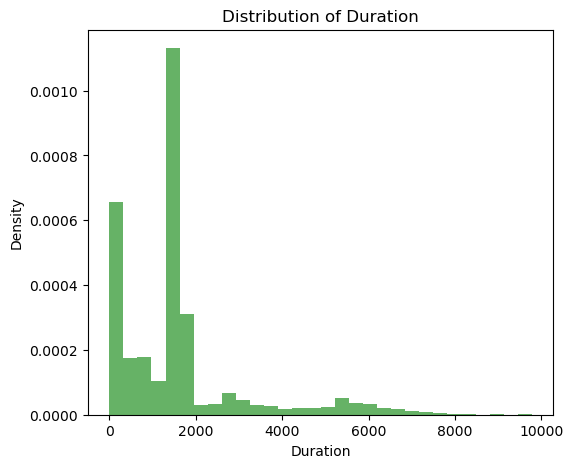

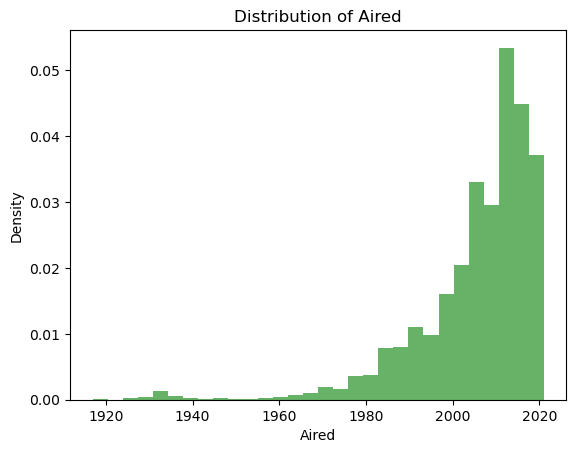

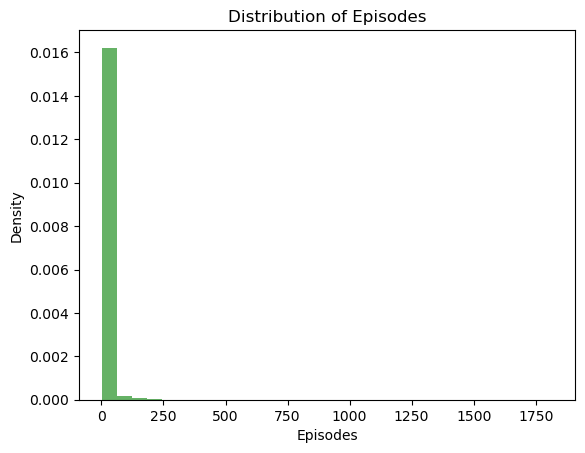

In [10]:
# Drop NaN values from 'Duration' column
duration = df['Duration'].dropna()
aired = df['Aired'].dropna()
episodes = df['Episodes'].dropna()

plt.figure(figsize=(6, 5))

# Create a histogram with a density curve
plt.hist(duration, bins=30, density=True, alpha=0.6, color='g')

plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.ylabel('Density')

plt.show()

# Repeat for 'Aired' and 'Episodes'
plt.hist(aired, bins=30, density=True, alpha=0.6, color='g')
plt.title('Distribution of Aired')
plt.xlabel('Aired')
plt.ylabel('Density')
plt.show()

plt.hist(episodes, bins=30, density=True, alpha=0.6, color='g')
plt.title('Distribution of Episodes')
plt.xlabel('Episodes')
plt.ylabel('Density')
plt.show()


Dropping the columns that are not required for the analysis.

In [11]:
columns_to_drop = ['Type', 'Rating', 'Genres', 'Score-1', 'Score-2', 'Score-3', 'Score-4', 'Score-5', 'Score-6', 'Score-7', 'Score-8', 'Score-9', 'Score-10', 
                   'Ranked', 'Favorites', 'Members' , 'Watching' , 'On-Hold' , 'Completed', 'Dropped', 'Plan to Watch', 
                   'MAL_ID', 'Name', 'English name' , 'Japanese name' , 'Premiered' , 'Producers', 'Licensors', 
                   'Source', 'Studios', 
                   'Unknown_Genre','Hentai', 'Yuri', 'Yaoi','Favorites']

df = df.drop(columns_to_drop, axis=1)
df.columns

Index(['Score', 'Episodes', 'Aired', 'Duration', 'Popularity', 'Action',
       'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space', 'Mystery', 'Shounen',
       'Police', 'Supernatural', 'Magic', 'Fantasy', 'Sports', 'Josei',
       'Romance', 'Slice of Life', 'Cars', 'Seinen', 'Horror', 'Psychological',
       'Thriller', 'Super Power', 'Martial Arts', 'School', 'Ecchi', 'Vampire',
       'Military', 'Historical', 'Dementia', 'Mecha', 'Demons', 'Samurai',
       'Game', 'Shoujo', 'Harem', 'Music', 'Shoujo Ai', 'Shounen Ai', 'Kids',
       'Parody'],
      dtype='object')

In [12]:

scaler = StandardScaler()

# Fit the scaler to the 'Aired', 'Completed', 'Dropped', and 'Favorites' columns and transform them
df[['Episodes', 'Duration', 'Aired', 'Popularity']] = scaler.fit_transform(df[['Episodes', 'Duration', 'Aired', 'Popularity']])

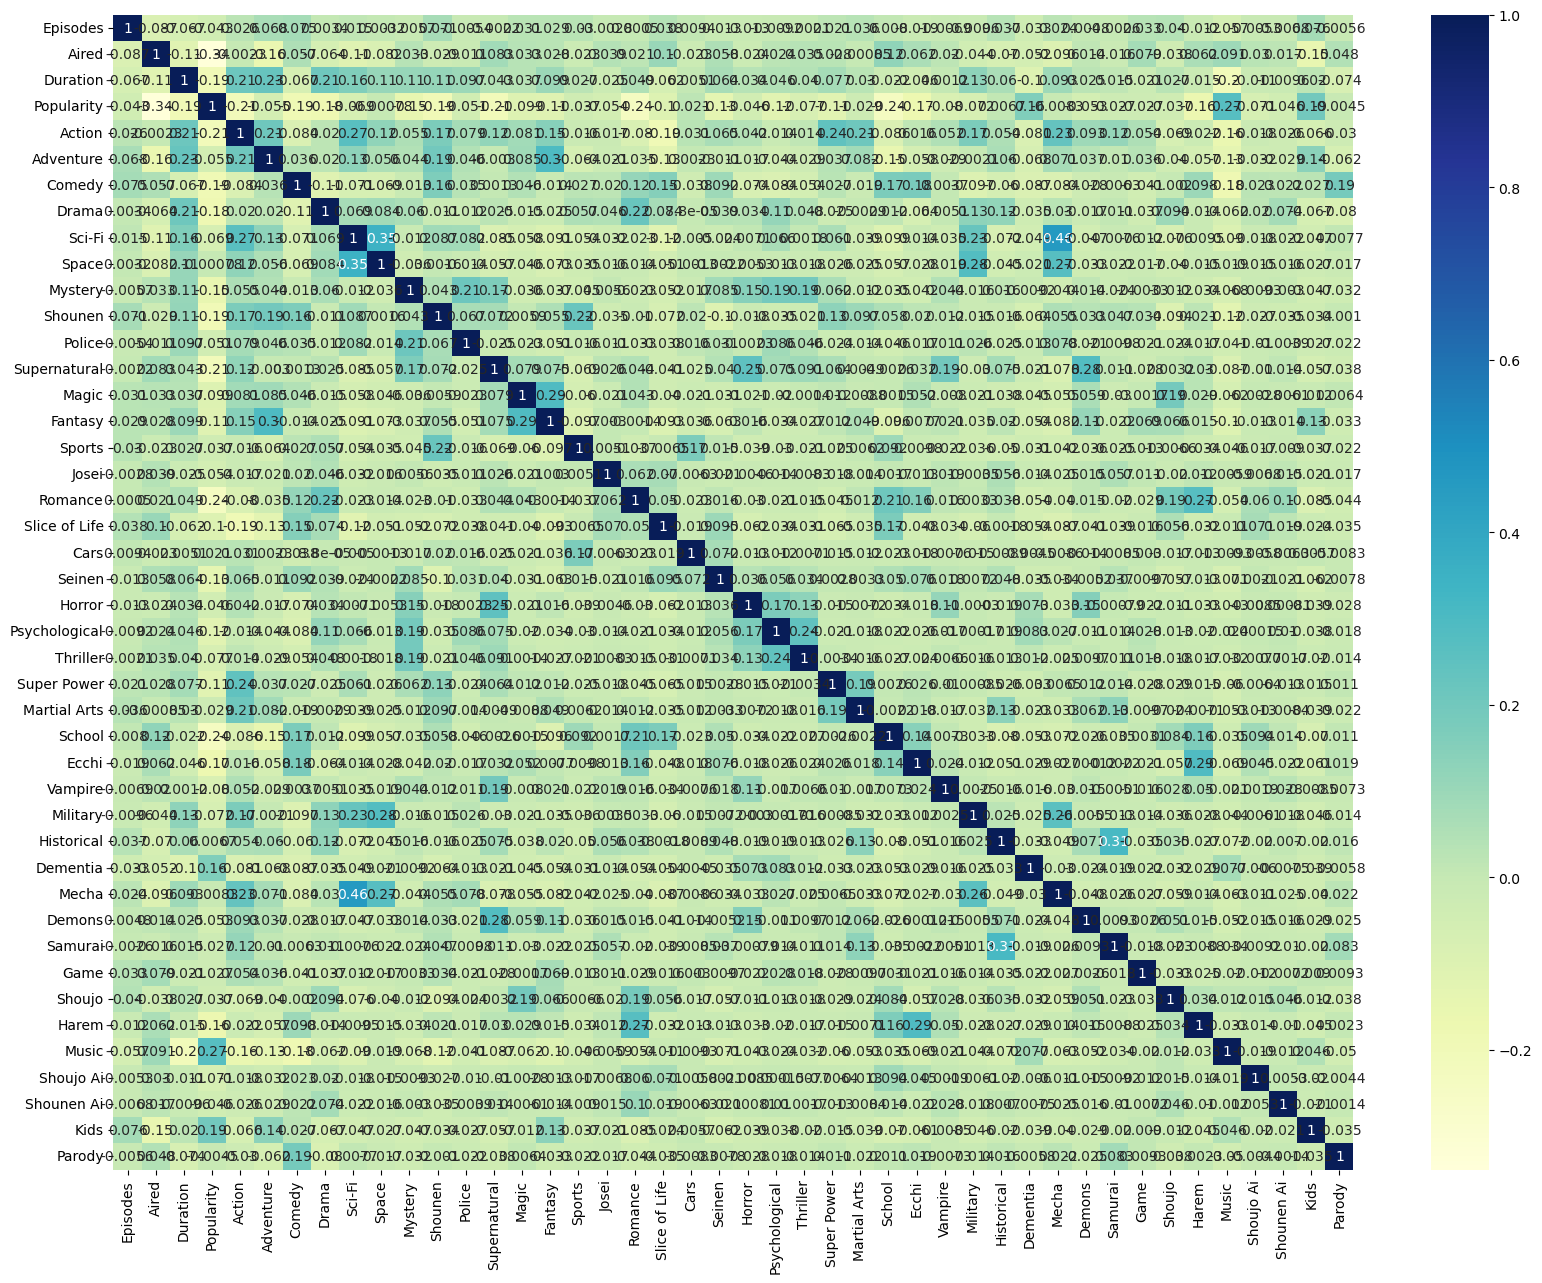

In [13]:
X = df.drop('Score', axis=1)
y = df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20,15))
sns.heatmap(X.corr(), annot=True, cmap='YlGnBu')
plt.show()

# OLS Regression with Popularity and without RFE

### Checking VIF to ensure that the independent variables are not correlated with each other.

In [14]:
def calculate_vif(X, index):
    mask = np.arange(X.shape[1]) != index
    model = LinearRegression()
    model.fit(X.iloc[:, mask], X.iloc[:, index])
    r_squared = model.score(X.iloc[:, mask], X.iloc[:, index])
    return 1 / (1 - r_squared)

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

vif_data["VIF"] = [calculate_vif(X_train, i) for i in range(X_train.shape[1])]

print(vif_data)

          feature       VIF
0        Episodes  1.054445
1           Aired  1.326885
2        Duration  1.270349
3      Popularity  1.816506
4          Action  1.469927
5       Adventure  1.325024
6          Comedy  1.302017
7           Drama  1.223245
8          Sci-Fi  1.512622
9           Space  1.240328
10        Mystery  1.194101
11        Shounen  1.282270
12         Police  1.095431
13   Supernatural  1.283341
14          Magic  1.163737
15        Fantasy  1.312987
16         Sports  1.166109
17          Josei  1.028853
18        Romance  1.298214
19  Slice of Life  1.177102
20           Cars  1.043353
21         Seinen  1.104628
22         Horror  1.151340
23  Psychological  1.149531
24       Thriller  1.101392
25    Super Power  1.132557
26   Martial Arts  1.130072
27         School  1.217930
28          Ecchi  1.186583
29        Vampire  1.073063
30       Military  1.196211
31     Historical  1.203751
32       Dementia  1.067664
33          Mecha  1.388514
34         Demons  1

In [15]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

Cross-validation scores: [0.57083823 0.60133609 0.56778723 0.59231058 0.59673233]
Mean cross-validation score: 0.5858008917984667
Standard Deviation of cross-validation score: 0.013795563133882019


Text(0, 0.5, 'Score')

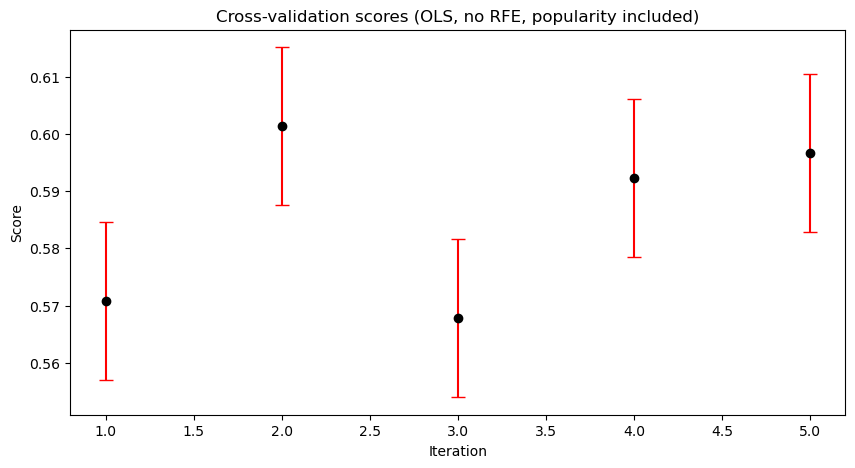

In [16]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (OLS, no RFE, popularity included)')
plt.xlabel('Iteration')
plt.ylabel('Score')

In [17]:

model.fit(X_train, y_train)
# for feature, coef in zip(X_train.columns, model.coef_):
#     print(f"{feature}: {coef}")

y_pred = model.predict(X_test)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

R-squared Score: 0.5953246851101126
Mean Squared Error: 0.31119973857692435
Mean Absolute Error: 0.42352268215154754


# OLS Regression with Popularity and RFE

In [18]:

model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=10)

X_train_rfe = rfe.fit_transform(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

model.fit(X_train_rfe, y_train)

selected_features = pd.Series(rfe.support_, index = X_train.columns)
print(selected_features[selected_features==True].index)

X_test_rfe = rfe.transform(X_test)
y_pred = model.predict(X_test_rfe)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")



Cross-validation scores: [0.57083823 0.60133609 0.56778723 0.59231058 0.59673233]
Mean cross-validation score: 0.5858008917984667
Standard Deviation of cross-validation score: 0.013795563133882019
Index(['Popularity', 'Drama', 'Mystery', 'Shounen', 'Seinen', 'Horror',
       'Ecchi', 'Historical', 'Dementia', 'Kids'],
      dtype='object')
R-squared Score: 0.5498798295571252
Mean Squared Error: 0.346147329021387
Mean Absolute Error: 0.44960321114107227


Text(0, 0.5, 'Score')

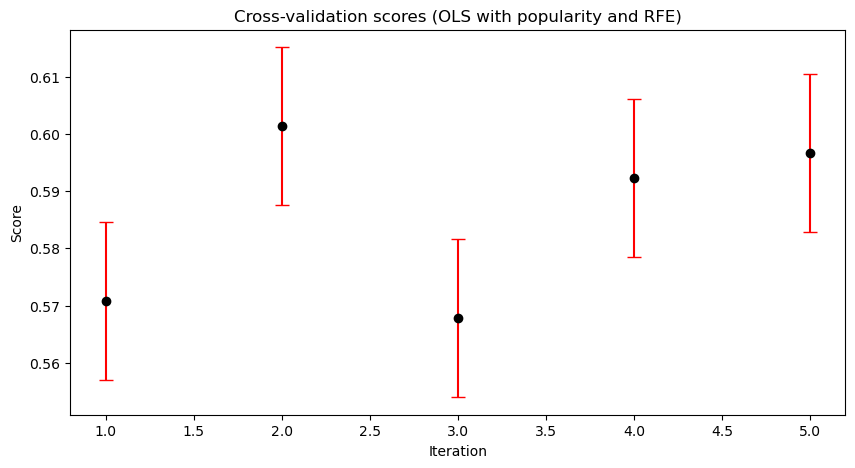

In [19]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (OLS with popularity and RFE)')
plt.xlabel('Iteration')
plt.ylabel('Score')

# Ridge Regression with Popularity and without RFE

In [20]:
def calculate_vif(X, index):
    mask = np.arange(X.shape[1]) != index
    model = Ridge(alpha=1.0)
    model.fit(X.iloc[:, mask], X.iloc[:, index])
    r_squared = model.score(X.iloc[:, mask], X.iloc[:, index])

    # Calculate and return the VIF
    return 1 / (1 - r_squared)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = [calculate_vif(X_train, i) for i in range(X_train.shape[1])]

print(vif_data)

          feature       VIF
0        Episodes  1.054445
1           Aired  1.326884
2        Duration  1.270348
3      Popularity  1.816502
4          Action  1.469923
5       Adventure  1.325022
6          Comedy  1.302015
7           Drama  1.223244
8          Sci-Fi  1.512620
9           Space  1.240328
10        Mystery  1.194096
11        Shounen  1.282267
12         Police  1.095430
13   Supernatural  1.283335
14          Magic  1.163736
15        Fantasy  1.312986
16         Sports  1.166097
17          Josei  1.028852
18        Romance  1.298209
19  Slice of Life  1.177100
20           Cars  1.043353
21         Seinen  1.104624
22         Horror  1.151338
23  Psychological  1.149526
24       Thriller  1.101391
25    Super Power  1.132555
26   Martial Arts  1.130071
27         School  1.217928
28          Ecchi  1.186581
29        Vampire  1.073063
30       Military  1.196210
31     Historical  1.203744
32       Dementia  1.067664
33          Mecha  1.388512
34         Demons  1

In [21]:
model = Ridge(alpha=1.0)

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

Cross-validation scores: [0.57082602 0.60140112 0.56779908 0.59233712 0.59673632]
Mean cross-validation score: 0.5858199346884533
Standard Deviation of cross-validation score: 0.013812915294371094


In [22]:
model.fit(X_train, y_train)

# for feature, coef in zip(X_train.columns, model.coef_):
#     print(f"{feature}: {coef}")

y_pred = model.predict(X_test)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

R-squared Score: 0.5953306727960563
Mean Squared Error: 0.31119513398101295
Mean Absolute Error: 0.4234897242147557


Text(0, 0.5, 'Score')

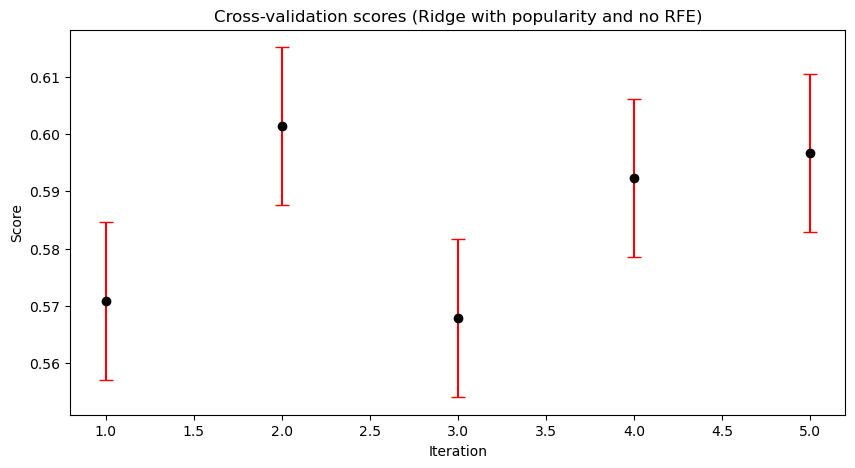

In [23]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (Ridge with popularity and no RFE)')
plt.xlabel('Iteration')
plt.ylabel('Score')

# Ridge Regression with Popularity and RFE

In [24]:
model = Ridge(alpha=1.0)

rfe = RFE(estimator=model, n_features_to_select=10)

X_train_rfe = rfe.fit_transform(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"Cross-validation scores: {scores}")

print(f"Mean cross-validation score: {scores.mean()}")

print(f"Standard Deviation of cross-validation score: {scores.std()}")

model.fit(X_train_rfe, y_train)

selected_features = pd.Series(rfe.support_, index = X_train.columns)
print(selected_features[selected_features==True].index)

X_test_rfe = rfe.transform(X_test)
y_pred = model.predict(X_test_rfe)

print(f"R-squared Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

Cross-validation scores: [0.57082602 0.60140112 0.56779908 0.59233712 0.59673632]
Mean cross-validation score: 0.5858199346884533
Standard Deviation of cross-validation score: 0.013812915294371094
Index(['Popularity', 'Drama', 'Mystery', 'Shounen', 'Seinen', 'Horror',
       'Ecchi', 'Historical', 'Dementia', 'Kids'],
      dtype='object')
R-squared Score: 0.5498679429062934
Mean Squared Error: 0.34615646998574856
Mean Absolute Error: 0.4495900824595428


Text(0, 0.5, 'Score')

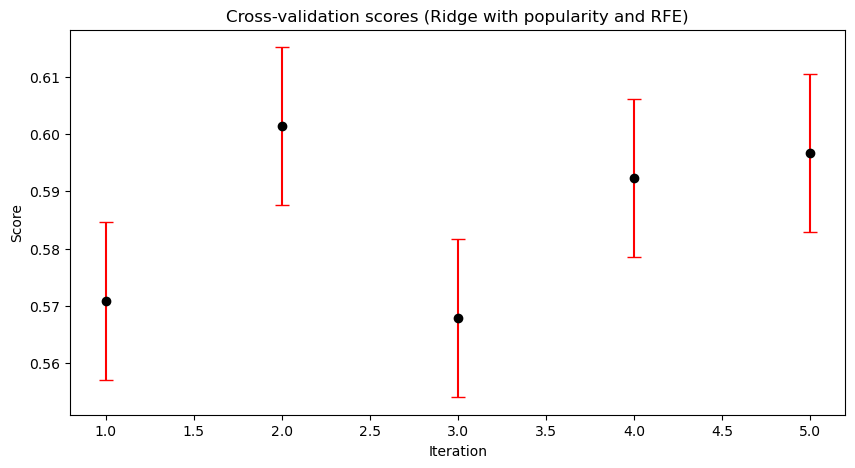

In [25]:
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, 6), scores, yerr=scores.std(), fmt='o', color='black', ecolor='red', capsize=5)
plt.title('Cross-validation scores (Ridge with popularity and RFE)')
plt.xlabel('Iteration')
plt.ylabel('Score')